# Data loading

In [2]:
import os
import boto3
from dotenv import load_dotenv
import io 
import pandas as pd

load_dotenv()

YC_ACCESS_KEY_ID = os.getenv("YC_ACCESS_KEY_ID")
YC_SECRET_ACCESS_KEY = os.getenv("YC_SECRET_ACCESS_KEY")
YC_ENDPOINT_URL = os.getenv("YC_ENDPOINT_URL")
YC_BUCKET_NAME = os.getenv("YC_BUCKET_NAME")

In [3]:
session = boto3.session.Session()
s3_client = session.client(
    service_name='s3',
    endpoint_url=YC_ENDPOINT_URL,
    aws_access_key_id=YC_ACCESS_KEY_ID,
    aws_secret_access_key=YC_SECRET_ACCESS_KEY
)

In [4]:
import gzip

file_names = ["item_categories.csv.gzip", "items.csv.gzip", "sample_submission.csv.gzip", "shops.csv.gzip", "test.csv.gzip", "train.csv.gzip"]
data_location = "filtered_data/"

data_storage = dict()
for file_name in file_names:
    response = s3_client.get_object(Bucket=YC_BUCKET_NAME, Key=f'{data_location}{file_name}')
    data_storage[file_name[: len(file_name) - 9]] = pd.read_csv(io.BytesIO(response['Body'].read()), compression='gzip')

data_storage["train"]['date'] = pd.to_datetime(data_storage["train"]['date'], format = '%Y-%m-%d')



# EDA

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
print("--- Data Structure and Types ---")
data_storage['train'].info()

--- Data Structure and Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2361351 entries, 0 to 2361350
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 108.1 MB


The dataset is **complete**, with all columns having the same number of non-null entries, indicating **no missing values**.


In [7]:
print("\n--- Descriptive Statistics ---")
data_storage['train'].describe(include='all')


--- Descriptive Statistics ---


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2361351,2.361351e+06,2.361351e+06,2.361351e+06,2.361351e+06,2.361351e+06
mean,2014-04-19 18:15:24.198055424,1.511148e+01,3.230267e+01,1.010623e+04,7.621577e+02,1.131942e+00
min,2013-01-01 00:00:00,0.000000e+00,2.000000e+00,1.000000e+00,7.000000e-02,1.000000e+00
25%,2013-08-13 00:00:00,7.000000e+00,2.100000e+01,4.368000e+03,2.490000e+02,1.000000e+00
50%,2014-03-22 00:00:00,1.400000e+01,3.100000e+01,9.019000e+03,3.990000e+02,1.000000e+00
75%,2014-12-23 00:00:00,2.300000e+01,4.600000e+01,1.559100e+04,9.990000e+02,1.000000e+00
max,2015-10-31 00:00:00,3.300000e+01,5.900000e+01,2.216900e+04,5.999000e+03,5.000000e+00
std,NaN,9.547572e+00,1.641148e+01,6.324963e+03,8.167837e+02,4.774745e-01


The significant difference between the mean and the median indicates a **skewed distribution**. This occurs when the mean is pulled towards a few **extreme values**, while the median remains a more stable measure of central tendency.

 ## Item_price check

In [10]:
data_storage['train']['item_price'].describe()

count    2.361351e+06
mean     7.621577e+02
std      8.167837e+02
min      7.000000e-02
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      5.999000e+03
Name: item_price, dtype: float64

Minimum item_price is greater than 0. Good sign

<Axes: xlabel='item_price', ylabel='Count'>

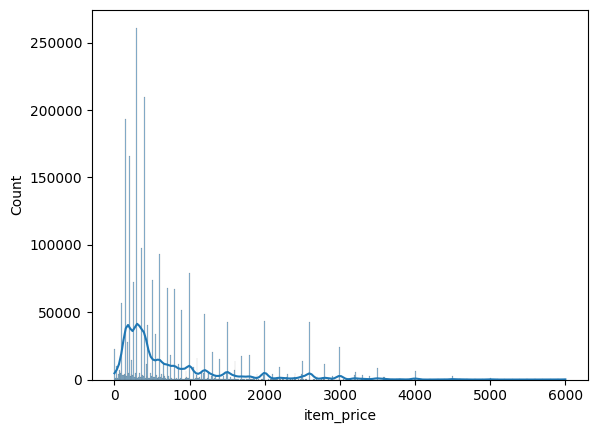

In [15]:
sns.histplot(data=data_storage['train'], x='item_price', kde=True)

 Deviates from the normal distribution.

 Has appreciable positive skewness.
 
 Shows peakedness.



In [16]:
print("Skewness: %f" % data_storage['train']['item_price'].skew())
print("Kurtosis: %f" % data_storage['train']['item_price'].kurt())

Skewness: 2.162945
Kurtosis: 5.463633


Data really containts assymetry. Lets try to use Log

Transformed Skewness: -0.673529
Transformed Kurtosis: 3.001422


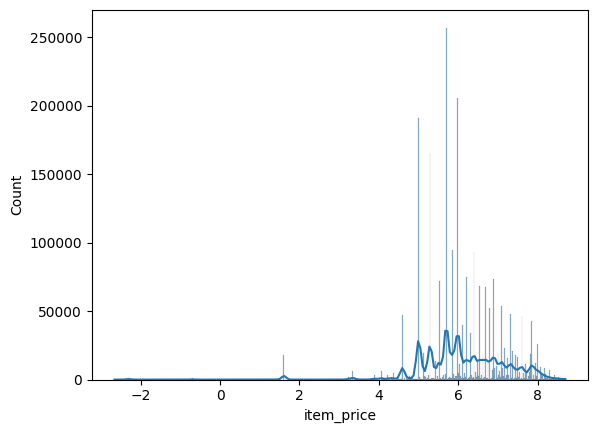

In [22]:
sns.histplot(data=data_storage['train'], x=np.log(data_storage['train']['item_price']), kde=True)
transformed_price = np.log1p(data_storage['train']['item_price'])

print("Transformed Skewness: %f" % transformed_price.skew())
print("Transformed Kurtosis: %f" % transformed_price.kurt())

Log trabsform really makes **item_price** look as a normal distribution. It might be a usefull step.

In [25]:
print("--- items table analysis ---")
data_storage['items'].info()
print("\nUnique items count:", data_storage['items']['item_id'].nunique())

--- items table analysis ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB

Unique items count: 22170


The `items` table contains a total of **22,170 unique items**. The data types are appropriate, and there are no missing values. 

In [26]:
print("--- shops table analysis ---")
data_storage['shops'].info()
print("\nUnique shops count:", data_storage['shops']['shop_id'].nunique())

--- shops table analysis ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
 2   shop_city  60 non-null     object
 3   shop_type  60 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.0+ KB

Unique shops count: 60


The `shops` table contains **60 unique shops**. The data is complete with no missing values.

In [27]:
month_sales = df_monthly = (
    data_storage['train'].groupby(['date_block_num', 'shop_id', 'item_id'])
    .agg(
        item_cnt_month_=('item_cnt_day', 'sum'),
        item_price_=('item_price', 'mean')
    )
    .reset_index()
)



### Data Aggregation by Month

The daily sales data is grouped by `date_block_num`, `shop_id`, and `item_id` to create a monthly sales DataFrame. This aggregation reduces data noise and aligns the features with the competition's monthly target variable.

* `item_cnt_day` is summed to get the total monthly sales (`item_cnt_month`).
* `item_price` is averaged to get the mean monthly price for each item.

In [28]:
month_sales.head()

,date_block_num,shop_id,item_id,item_cnt_month_,item_price_
0,0,2,27,1.0,2499.0
1,0,2,33,1.0,499.0
2,0,2,317,1.0,299.0
3,0,2,438,1.0,299.0
4,0,2,471,2.0,399.0


--- Top 5 Categories by Average Monthly Sales ---
| item_category_name                  | item_category_id   | item_category_type   | item_category_subtype      |
|:------------------------------------|:-------------------|:---------------------|:---------------------------|
| Игры - PS3                          | 19                 | Игры                 | PS3                        |
| Игры PC - Стандартные издания       | 30                 | Игры PC              | Стандартные издания        |
| Кино - Blu-Ray                      | 37                 | Кино                 | Blu                        |
| Кино - DVD                          | 40                 | Кино                 | DVD                        |
| Музыка - CD локального производства | 55                 | Музыка               | CD локального производства |


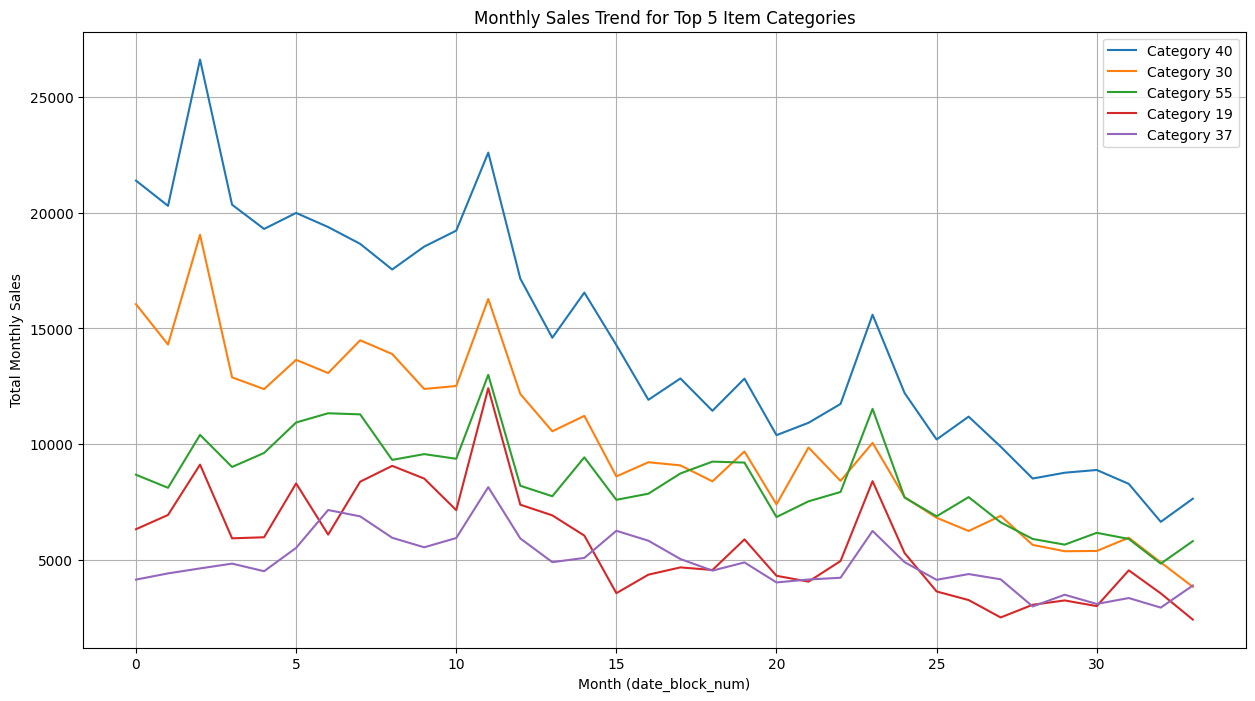

In [29]:
def analyze_categorical_features(df_train, df_items, df_item_categories):
    df_merged = df_train.merge(df_items[['item_id', 'item_category_id']], on='item_id', how='left')
    monthly_sales_by_cat = df_merged.groupby(['date_block_num', 'item_category_id'])['item_cnt_month_'].sum().reset_index()
    avg_sales_per_cat = monthly_sales_by_cat.groupby('item_category_id')['item_cnt_month_'].mean().reset_index()
    top_5_categories = avg_sales_per_cat.sort_values('item_cnt_month_', ascending=False).head(5)['item_category_id'].tolist()
    
    print("--- Top 5 Categories by Average Monthly Sales ---")
    top_5_names = df_item_categories[df_item_categories['item_category_id'].isin(top_5_categories)]
    print(top_5_names.to_markdown(index=False, numalign="left", stralign="left"))
    
    plt.figure(figsize=(15, 8))
    
    for category in top_5_categories:
        category_data = monthly_sales_by_cat[monthly_sales_by_cat['item_category_id'] == category]
        plt.plot(category_data['date_block_num'], category_data['item_cnt_month_'], label=f'Category {category}')

    plt.title('Monthly Sales Trend for Top 5 Item Categories')
    plt.xlabel('Month (date_block_num)')
    plt.ylabel('Total Monthly Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

analyze_categorical_features(month_sales, data_storage['items'], data_storage['item_categories'])

This graph shows an overall **downward trend** in sales over the entire period. There is strong **seasonality**, with a sharp spike in sales at the end of each year, likely due to holidays. A notable observation is the **sharp drop in sales** in the last month, which may indicate the end of the data collection period.

The plot shows a significant shift in the data distribution, especially in the last month. This is a strong reason to **check for concept drift**.

In [30]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

window_size = 3

metrics_dict = {}

new_data = month_sales[month_sales['date_block_num'] > month_sales['date_block_num'].max() - window_size].copy()
new_data.drop(columns=['date_block_num'], inplace=True)
new_data['is_new'] = 1

features_to_check = ['item_id', 'shop_id', 'item_cnt_month', 'item_price_mean']

for i in range(month_sales['date_block_num'].max() - window_size, window_size, -1):
    old_data = month_sales[(month_sales['date_block_num'] < i) & (month_sales['date_block_num'] >= i - window_size)].copy()
    old_data.drop(columns=['date_block_num'], inplace=True)

    old_data['is_new'] = 0

    combined_df = pd.concat([old_data, new_data], ignore_index=True)
    X = combined_df.drop(columns=['is_new'])
    y = combined_df['is_new']

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    metrics_dict[i] = accuracy

metrics_df = pd.DataFrame(metrics_dict.items(), columns=['window_start_month', 'accuracy'])
print("--- Concept Drift Detection Results ---")
print(metrics_df)

--- Concept Drift Detection Results ---
    window_start_month  accuracy
0                   30  0.663422
1                   29  0.702863
2                   28  0.742456
3                   27  0.769769
4                   26  0.794530
5                   25  0.825115
6                   24  0.845748
7                   23  0.870530
8                   22  0.874013
9                   21  0.882455
10                  20  0.886586
11                  19  0.891275
12                  18  0.892513
13                  17  0.892088
14                  16  0.894481
15                  15  0.899174
16                  14  0.898666
17                  13  0.896609
18                  12  0.900856
19                  11  0.905967
20                  10  0.911900
21                   9  0.912972
22                   8  0.907880
23                   7  0.911664
24                   6  0.909382
25                   5  0.917772
26                   4  0.909310


### !!Warning!!

The significant concept drift is present, as evidenced by the high classification accuracy in early periods. However, the model's performance drops as the time windows get closer, suggesting that the most recent data is the most relevant for forecasting. It is therefore recommended to **discard older data** and train the final model on the latest available months to improve its predictive power.

In [31]:
# just removing data surely having concept drift

train = month_sales[month_sales['date_block_num'] > 19]

<Axes: xlabel='item_cnt_month_', ylabel='item_price_'>

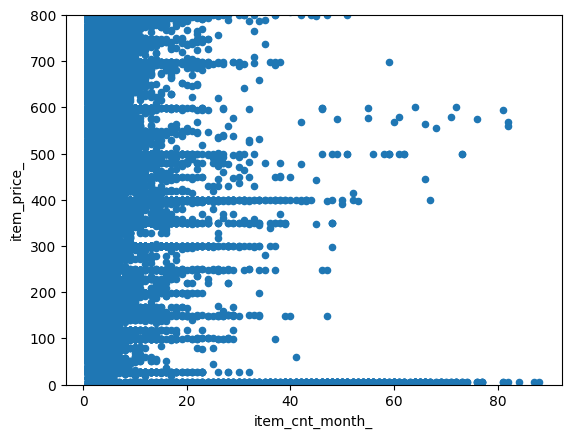

In [38]:
var = 'item_cnt_month_'
data = pd.concat([train['item_price_'], train[var]], axis=1)
data.plot.scatter(x=var, y='item_price_', ylim=(0,800))

**item_price_** might be not a super usefull feature due to almost to abvios dependenses between it and **item_cnt_minth**

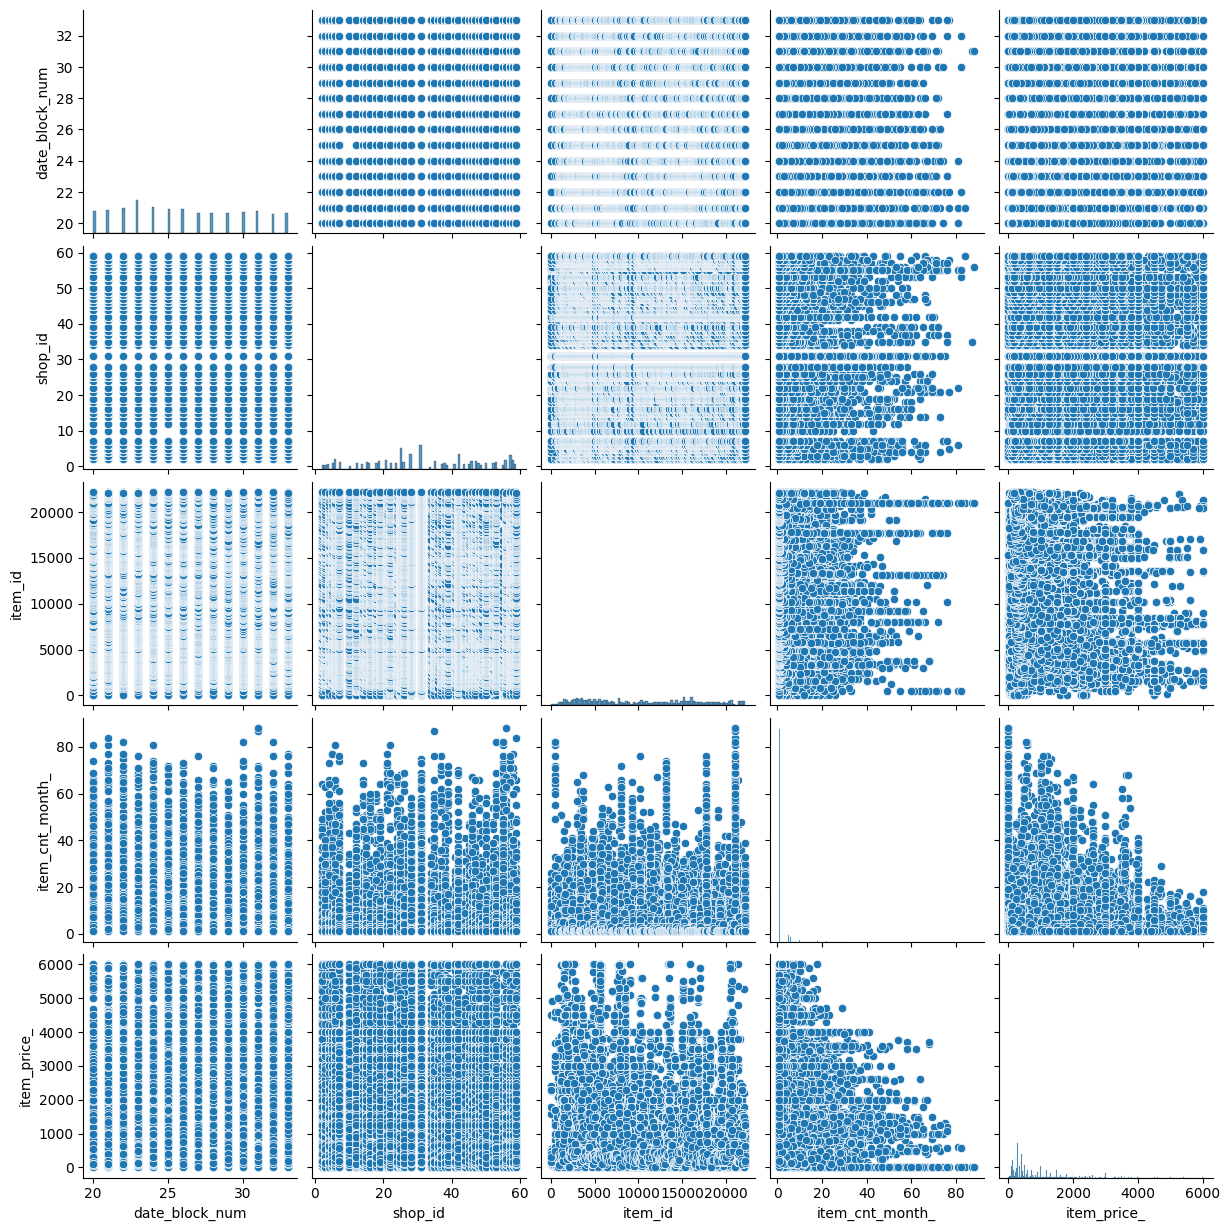

In [ ]:
cols = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month_', 'item_price_']
sns.pairplot(train[cols], height = 2.5)
plt.show()



This pair plot visualizes the relationships and distributions of key variables.

The off-diagonal plots display scatter plots, revealing the correlation between each pair of variables.

Note the strong positive skewness in the `item_cnt_month` variable, a common characteristic in sales data.

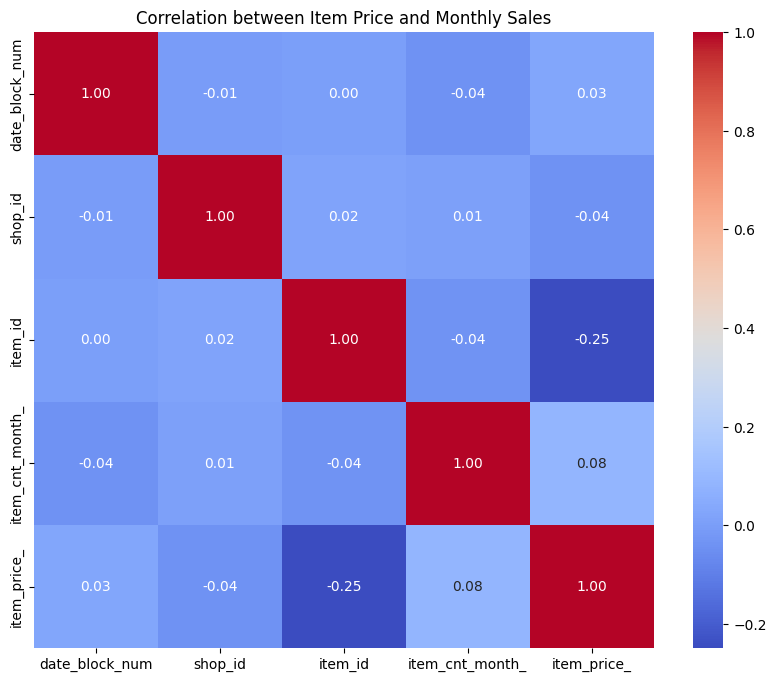

In [51]:
correlation_matrix = train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm'
)

plt.title('Correlation between Item Price and Monthly Sales')
plt.show()

The correlation of -0.08 between `item_price` and `item_cnt_month` indicates a **very weak negative linear relationship**. This means that as the price of an item changes, its monthly sales volume does not change in a predictable, linear fashion.

This result highlights that **price alone is not a strong predictor of sales**. To accurately forecast sales, your model will need to incorporate more complex features that capture **non-linear relationships** and other crucial factors such as seasonality, trends, and item popularity.

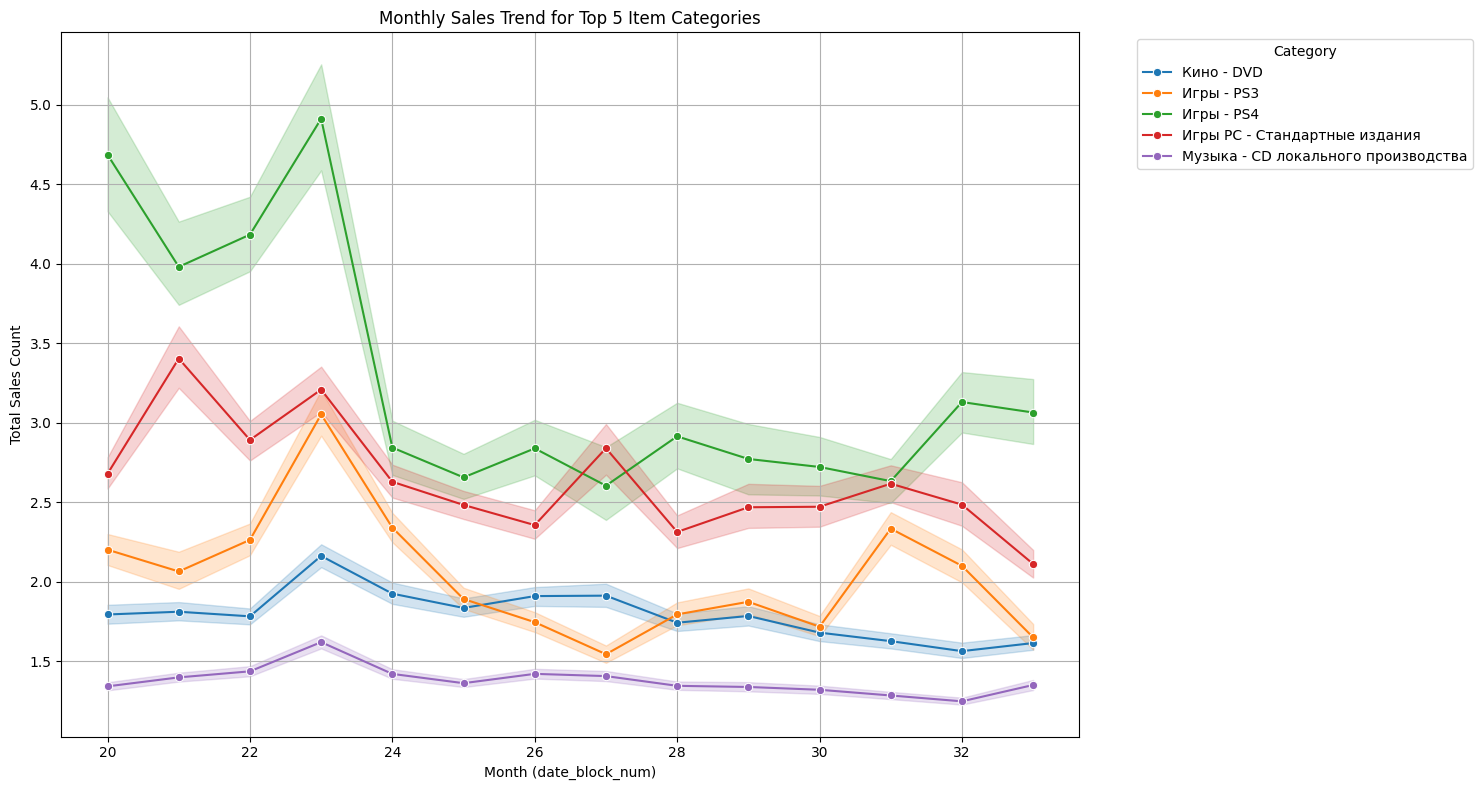

In [ ]:
def plot_sales_by_category(pre_grouped_df, items_df, item_categories_df):
    df_merged = pd.merge(pre_grouped_df, items_df[['item_id', 'item_category_id']], on='item_id', how='left')
    df_merged = pd.merge(df_merged, item_categories_df, on='item_category_id', how='left')
    
    top_5_categories = df_merged.groupby('item_category_name')['item_cnt_month_'].sum().nlargest(5).inde    x
    
    top_categories_df = df_merged[df_merged['item_category_name'].isin(top_5_categories)]
    plt.figure(figsize=(15, 8))
    sns.lineplot(data=top_categories_df, x='date_block_num', y='item_cnt_month_', hue='item_category_name', marker='o')

    plt.title('Monthly Sales Trend for Top 5 Item Categories')
    plt.xlabel('Month (date_block_num)')
    plt.ylabel('Total Sales Count')
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_sales_by_category(train, data_storage['items'], data_storage['item_categories'])

The plot shows a clear **downward sales trend** for all five low-performing shops over time. Their sales volume is consistently very low, rarely exceeding 200 units per month.

This data is unrepresentative of the overall market and could be **excluded from the training set** as it likely belongs to unprofitable or closed stores, which would negatively impact the model's predictive accuracy.

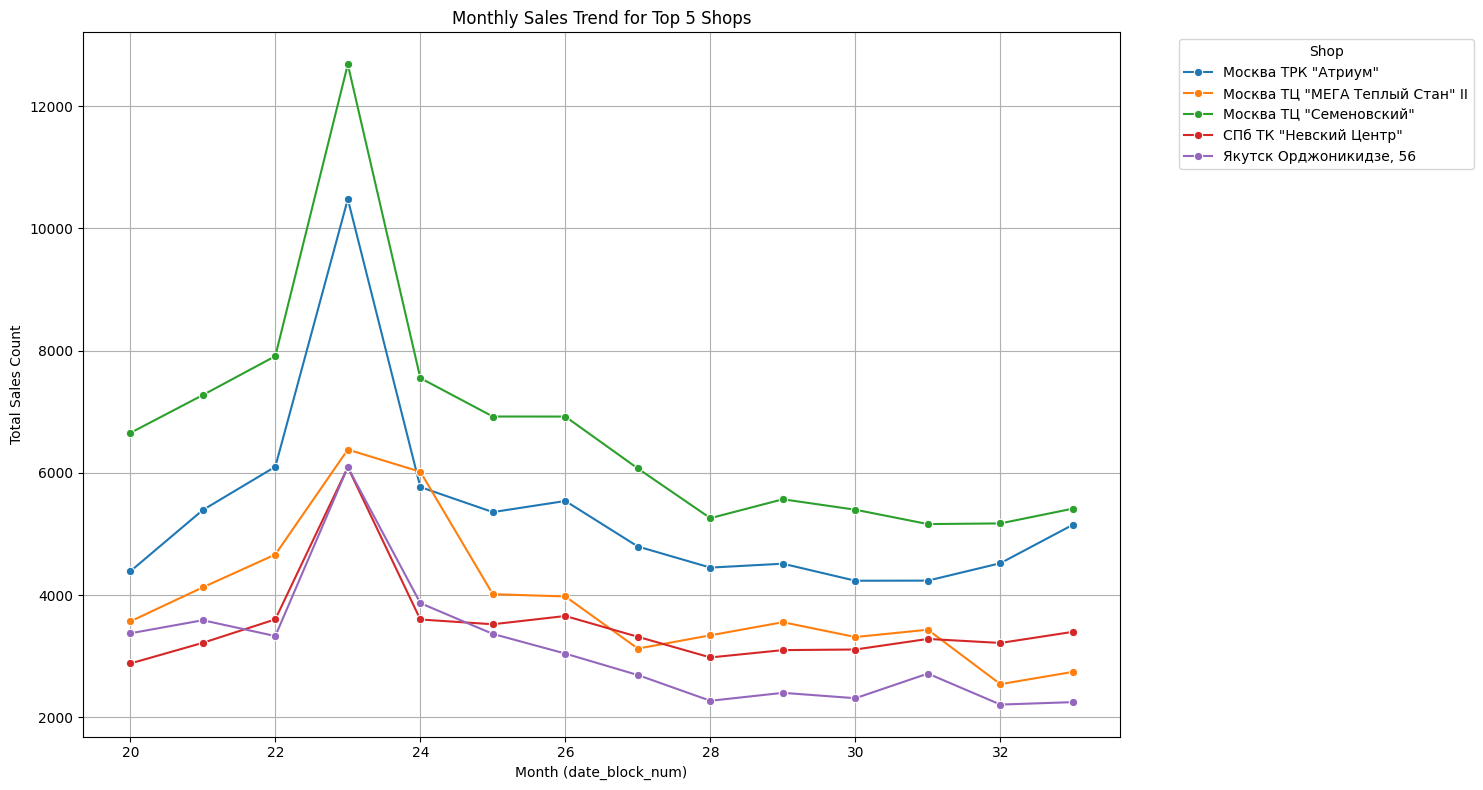

In [ ]:
def plot_sales_by_shop(train_df: pd.DataFrame, shops_df: pd.DataFrame):

    df_merged = pd.merge(train_df, shops_df, on='shop_id', how='left')
    monthly_sales_by_shop = df_merged.groupby(['date_block_num', 'shop_name'])['item_cnt_month_'].sum().reset_index()
    
    top_5_shops = monthly_sales_by_shop.groupby('shop_name')['item_cnt_month_'].sum().nlargest(5).index
    
    top_shops_df = monthly_sales_by_shop[monthly_sales_by_shop['shop_name'].isin(top_5_shops)]

    plt.figure(figsize=(15, 8))
    sns.lineplot(data=top_shops_df, x='date_block_num', y='item_cnt_month_', hue='shop_name', marker='o')

    plt.title('Monthly Sales Trend for Top 5 Shops')
    plt.xlabel('Month (date_block_num)')
    plt.ylabel('Total Sales Count')
    plt.legend(title='Shop', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_sales_by_shop(train, data_storage['shops'])

This key EDA plot shows a clear **downward trend** in overall sales. It also reveals strong **seasonality**, with significant sales peaks occurring annually. The abrupt drop at the end of the graph suggests a potential **concept drift** or simply the end of the data collection period, which must be considered for future forecasting.

### looking at **item_cnt_month_** distribution after groupping

/tmp/ipykernel_24864/1122679979.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['item_cnt_month_'])


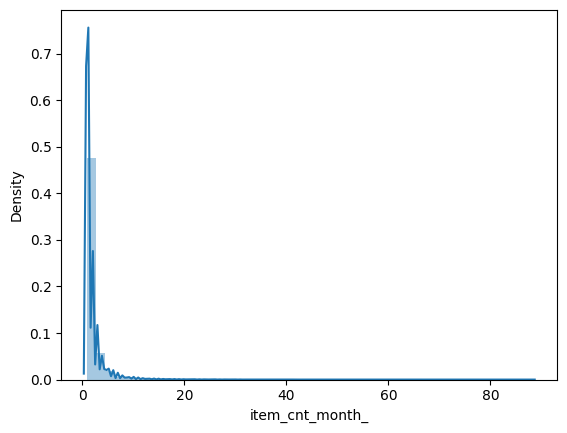

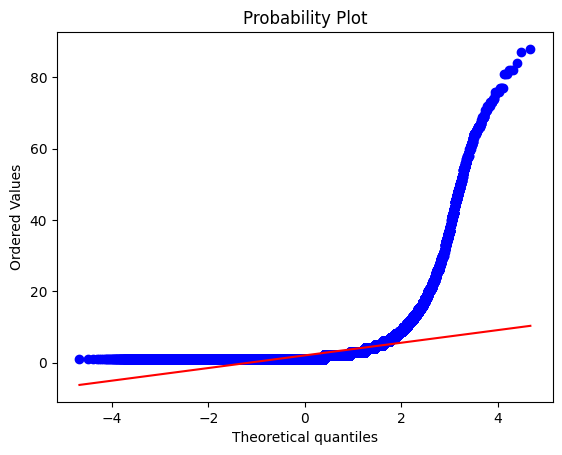

In [57]:
from scipy import stats
sns.distplot(train['item_cnt_month_'])
fig = plt.figure()
res = stats.probplot(train['item_cnt_month_'], plot=plt)

**item_cnt_month_** is not looks like normal distribution. Lets try to use log transform.

In [62]:
train['log_item_cnt_month_'] = np.log(train['item_cnt_month_'])

/tmp/ipykernel_24864/4087176460.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['log_item_cnt_month_'] = np.log(train['item_cnt_month_'])


/tmp/ipykernel_24864/493961769.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['log_item_cnt_month_'])


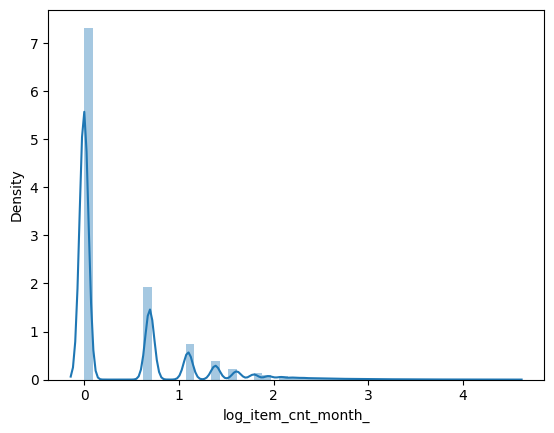

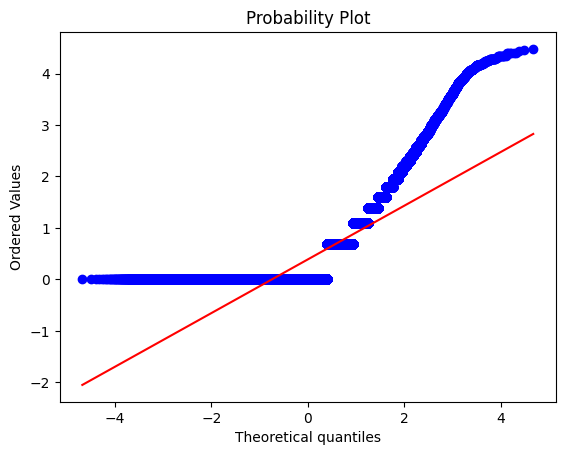

In [63]:
from scipy import stats
sns.distplot(train['log_item_cnt_month_'])
fig = plt.figure()
res = stats.probplot(train['log_item_cnt_month_'], plot=plt)

And we cant make it looks like normal distibution using log tranform.

It is the reason not to use models susceptible to the target distribution.